In [1]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
class HeartFailureDataSet:
    def __init__(self):
        self.data = pd.read_csv("heart_failure_clinical_records.csv")
        self.x = self.data[["age", "anaemia", "creatinine_phosphokinase", "diabetes", "ejection_fraction", "high_blood_pressure", "platelets", "serum_creatinine", "serum_sodium", "sex", "smoking","time"]]
        self.y = self.data["DEATH_EVENT"]
        self.numeric_columns = ["age", "creatinine_phosphokinase", "ejection_fraction", "platelets", "serum_creatinine", "serum_sodium", "time"]
        self.X_train, self.X_test, self.y_train, self.y_test = train_test_split(self.x, self.y, random_state=104, test_size=0.2, shuffle=True) 
        self.scaler = StandardScaler()
        self.scaler = self.scaler.fit(self.X_train[self.numeric_columns])
        self.X_train[self.numeric_columns] = self.scaler.transform(self.X_train[self.numeric_columns])  
        self.X_test[self.numeric_columns] = self.scaler.transform(self.X_test[self.numeric_columns])  

    def get_training_data(self):
        return self.X_train.copy(), self.y_train.copy()

    def get_test_data(self):
        return self.X_test.copy(), self.y_test.copy()
    
    def get_numeric_columns(self):
        return self.numeric_columns
        
    def get_statistics(self):
        return self.data.describe()

    def get_y_balance(self):
        return self.y.sum() / self.y.count()

    def get_description(self):
        return """This dataset contains the medical records of 5000 patients who had heart failure, 
        collected during their follow-up period, where each patient profile has 13 clinical features."""

In [2]:
class IBaseModel:
    def __init__(self):
        pass

    def train(self):
        pass

    def get_probabilities(self):
        pass
        
    def get_predictions(self):
        pass
    
    def get_coefficients(self):
        pass
    
    def get_classes(self):
        pass

In [3]:
from sklearn.metrics import roc_curve, auc, precision_recall_fscore_support, confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import learning_curve
import matplotlib.pyplot as plt
import numpy as np

class ModelMetrics:
    def __init__(self, model: IBaseModel, data: HeartFailureDataSet):
        self.model = model
        if not self.model.trained: self.model.train()  
        self.data = data
        self.x_test, self.y_test = self.data.get_test_data();
        self.x_train, self.y_train = self.data.get_training_data();
        
    def get_prf(self):
        self.prediction = self.model.get_predictions(self.x_test)
        print(self.model.name)
        precision_0, recall_0, f1_0, support_0 = precision_recall_fscore_support(self.y_test, self.prediction, average='binary', pos_label=0)
        precision_1, recall_1, f1_1, support_1 = precision_recall_fscore_support(self.y_test, self.prediction, average='binary', pos_label=1)
        return {
            "Class 0":{
                "Precision": precision_0,
                "Recall": recall_0,
                "F1": f1_0
            },
            "Class 1":{
                "Precision": precision_1,
                "Recall": recall_1,
                "F1": f1_1
            }
        }

    def show_ROC(self):
        probability = self.model.get_probabilities(self.x_test)
        false_pos_0, true_pos_0, discard = roc_curve(self.y_test, probability[:, 0], pos_label=0)
        auc_0 = auc(false_pos_0, true_pos_0)
        
        false_pos_1, true_pos_1, discard = roc_curve(self.y_test, probability[:, 1], pos_label=1)
        auc_1 = auc(false_pos_1, true_pos_1)
        
        plt.plot(false_pos_0, true_pos_0, marker='.', label='Class 0', color='b')
        plt.plot(false_pos_1, true_pos_1, marker='.', label='Class 1', color='r')
        plt.xlabel('False Positive')
        plt.ylabel('True Positive')
        plt.title(self.model.name)
        plt.legend()
        plt.show()

    def show_learning_curve(self):
        train_sizes, train_scores, test_scores = learning_curve(self.model.model, self.x_train, self.y_train)
        plt.plot(train_sizes, np.mean(train_scores, axis=1),marker='.',color='b', label='Training Scores')
        plt.plot(train_sizes, np.mean(test_scores, axis=1),marker='.',color='orange', label='Testing Scores')
        plt.title(self.model.name)
        plt.xlabel('Training Sample Volume')
        plt.ylabel('Accuracy Percentage')
        plt.legend()
        plt.show()

    def display_coefficients(self):
        for column, coef in zip(list(self.x_train.columns), list(self.model.get_coefficients()[0])):
            print(f"{column}: {coef}")
            
    def plot_coefficients(self):
        # Extract the coefficients
        coefficients = self.model.get_coefficients()[0]
        features = self.x_train.columns

        # Create the trace plot
        plt.figure(figsize=(10, 6))
        plt.scatter(features, coefficients, color='b')
        plt.axhline(0, color='red', linestyle='--', linewidth=0.8)
        plt.title(self.model.name)
        plt.xlabel('Features')
        plt.ylabel('Coefficient Value')
        plt.xticks(rotation=90)
        plt.grid(True)
        plt.show()
        
    def get_confusion_matrix(self):
        cm = confusion_matrix(self.y_test, self.model.get_predictions(self.x_test))

        disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=self.model.get_classes())
        disp.plot(cmap=plt.cm.Blues)
        plt.title(self.model.name)
        plt.show()
    

In [4]:
from sklearn.linear_model import LogisticRegressionCV
class LogisticRegressionL2(IBaseModel):
    def __init__(self, x, y, C:int):
        self.model = LogisticRegressionCV(penalty="l2", cv=None, Cs=C)
        self.X_train = x
        self.y_train = y
        self.trained = False
        self.name = "LogisticRegressionL2"
    
    def train(self):
        assert len(self.X_train) == len(self.y_train)
        self.model.fit(self.X_train, self.y_train)
        self.Trained = True

    def get_probabilities(self, x):
        return self.model.predict_proba(x)

    def get_predictions(self, x):
        return self.model.predict(x)

    def get_coefficients(self):
        return self.model.coef_
    
    def get_classes(self):
        return self.model.classes_

In [5]:
class LogisticRegressionL1(IBaseModel):
    def __init__(self, x, y, C:int):
        self.model = LogisticRegressionCV(penalty="l1", Cs=C, solver="saga", cv=None)
        self.X_train = x
        self.y_train = y
        self.trained = False
        self.name = "LogisticRegressionL1"
    
    def train(self):
        assert len(self.X_train) == len(self.y_train)
        self.model.fit(self.X_train, self.y_train)
        self.Trained = True

    def get_probabilities(self, x):
        return self.model.predict_proba(x)

    def get_predictions(self, x):
        return self.model.predict(x)
    
    def get_coefficients(self):
        return self.model.coef_
    
    def get_classes(self):
        return self.model.classes_

In [6]:
data = HeartFailureDataSet()
x_train, y_train = data.get_training_data()
x_test, y_test = data.get_test_data()

In [7]:
from sklearn.linear_model import LogisticRegression
class LogisticRegressionNone(IBaseModel):
    def __init__(self, x, y):
        self.model = LogisticRegression(penalty=None, solver="saga")
        self.X_train = x
        self.y_train = y
        self.trained = False
        self.name = "LogisticRegressionNone"
    
    def train(self):
        assert len(self.X_train) == len(self.y_train)
        self.model.fit(self.X_train, self.y_train)
        self.Trained = True

    def get_probabilities(self, x):
        return self.model.predict_proba(x)

    def get_predictions(self, x):
        return self.model.predict(x)
    
    def get_coefficients(self):
        return self.model.coef_
    
    def get_classes(self):
        return self.model.classes_

In [8]:
lgn = LogisticRegressionNone(x_train, y_train)
lgnEval = ModelMetrics(lgn, data)
lgnEval.get_prf()

LogisticRegressionNone


{'Class 0': {'Precision': 0.8744884038199181,
  'Recall': 0.9183381088825215,
  'F1': 0.8958770090845563},
 'Class 1': {'Precision': 0.7865168539325843,
  'Recall': 0.695364238410596,
  'F1': 0.7381370826010545}}

In [9]:
lrl1 = LogisticRegressionL1(x_train, y_train, 100)
lrl1reval = ModelMetrics(lrl1, data)
lrl1reval.get_prf()

LogisticRegressionL1


{'Class 0': {'Precision': 0.8671140939597315,
  'Recall': 0.9255014326647565,
  'F1': 0.8953568953568953},
 'Class 1': {'Precision': 0.796078431372549,
  'Recall': 0.6721854304635762,
  'F1': 0.7289048473967684}}

In [10]:
lrl2 = LogisticRegressionL2(x_train, y_train, 100)
lrl2reval = ModelMetrics(lrl2, data)
lrl2reval.get_prf()

LogisticRegressionL2


{'Class 0': {'Precision': 0.8564102564102564,
  'Recall': 0.9570200573065902,
  'F1': 0.9039242219215156},
 'Class 1': {'Precision': 0.8636363636363636,
  'Recall': 0.6291390728476821,
  'F1': 0.7279693486590038}}

In [11]:
from sklearn.svm import LinearSVC
class LinearSVCL1(IBaseModel):
    def __init__(self, x, y, C:int):
        self.model = LinearSVC(penalty="l1", C=C, dual=False, loss='squared_hinge')
        self.X_train = x
        self.y_train = y
        self.trained = False
        self.name = "LinearSVCL1"
    
    def train(self):
        assert len(self.X_train) == len(self.y_train)
        self.model.fit(self.X_train, self.y_train)
        self.Trained = True

    def get_probabilities(self, x):
        return self.model._predict_proba_lr(x)

    def get_predictions(self, x):
        return self.model.predict(x)
    
    def get_coefficients(self):
        return self.model.coef_
    
    def get_classes(self):
        return self.model.classes_

In [12]:
svcl1 = LinearSVCL1(x_train, y_train, 100)
svcl1Eval = ModelMetrics(svcl1, data)

In [13]:
from sklearn.svm import NuSVC
class NuSupportSVC(IBaseModel):
    def __init__(self, x, y):
        self.model = NuSVC(kernel="linear", gamma='auto', probability=True)
        self.X_train = x
        self.y_train = y
        self.trained = False
        self.name = "NuSupportVectorClassifier"
    
    def train(self):
        assert len(self.X_train) == len(self.y_train)
        self.model.fit(self.X_train, self.y_train)
        self.Trained = True

    def get_probabilities(self, x):
        return self.model.predict_proba(x)

    def get_predictions(self, x):
        return self.model.predict(x)

    def get_coefficients(self):
        return self.model.coef_
    
    def get_classes(self):
        return self.model.classes_

In [14]:
nvsc = NuSupportSVC(x_train, y_train)
nsvcEval = ModelMetrics(nvsc, data)
nsvcEval.display_coefficients()

age: 0.27214104891422336
anaemia: 0.13640665937182928
creatinine_phosphokinase: 0.13391143427497348
diabetes: -0.013007130188686461
ejection_fraction: -0.37166560015856076
high_blood_pressure: 0.14054587186139003
platelets: 0.019087106343174336
serum_creatinine: 0.34381596512362683
serum_sodium: -0.16254914449540328
sex: 0.010808982002454864
smoking: -0.027423683390641135
time: -0.6709034235368434


In [15]:
from sklearn.svm import SVC
class LinearSVCL2(IBaseModel):
    def __init__(self, x, y, C:int):
        self.model = SVC(kernel='linear', C=C, probability=True)
        self.X_train = x
        self.y_train = y
        self.trained = False
        self.name = "LinearSVCL2"
    
    def train(self):
        assert len(self.X_train) == len(self.y_train)
        self.model.fit(self.X_train, self.y_train)
        self.Trained = True

    def get_probabilities(self, x):
        return self.model.predict_proba(x)

    def get_predictions(self, x):
        return self.model.predict(x)
    
    def get_coefficients(self):
        return self.model.coef_
    
    def get_classes(self):
        return self.model.classes_

In [16]:
svcl2 = LinearSVCL2(x_train, y_train, 100)
svcl2Eval = ModelMetrics(svcl2, data)

LogisticRegressionNone
LogisticRegressionNone
{'Class 0': {'Precision': 0.8744884038199181, 'Recall': 0.9183381088825215, 'F1': 0.8958770090845563}, 'Class 1': {'Precision': 0.7865168539325843, 'Recall': 0.695364238410596, 'F1': 0.7381370826010545}}


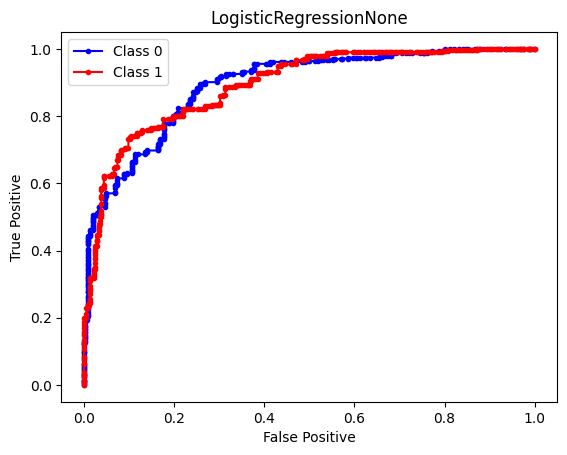

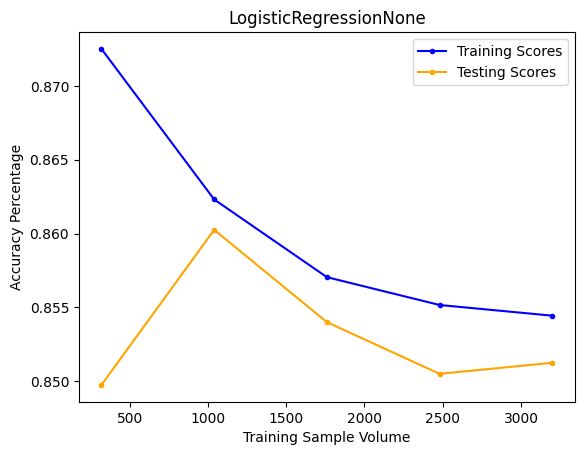

age: 0.5675876399207888
anaemia: 0.08949318792868939
creatinine_phosphokinase: 0.3113381728231514
diabetes: -0.12136576993678068
ejection_fraction: -0.8954684865075935
high_blood_pressure: 0.1357419566698011
platelets: -0.028232419719923577
serum_creatinine: 0.6667628854175172
serum_sodium: -0.32347005384567995
sex: -0.059544742320731224
smoking: 0.09321913180409208
time: -1.5865998596648498


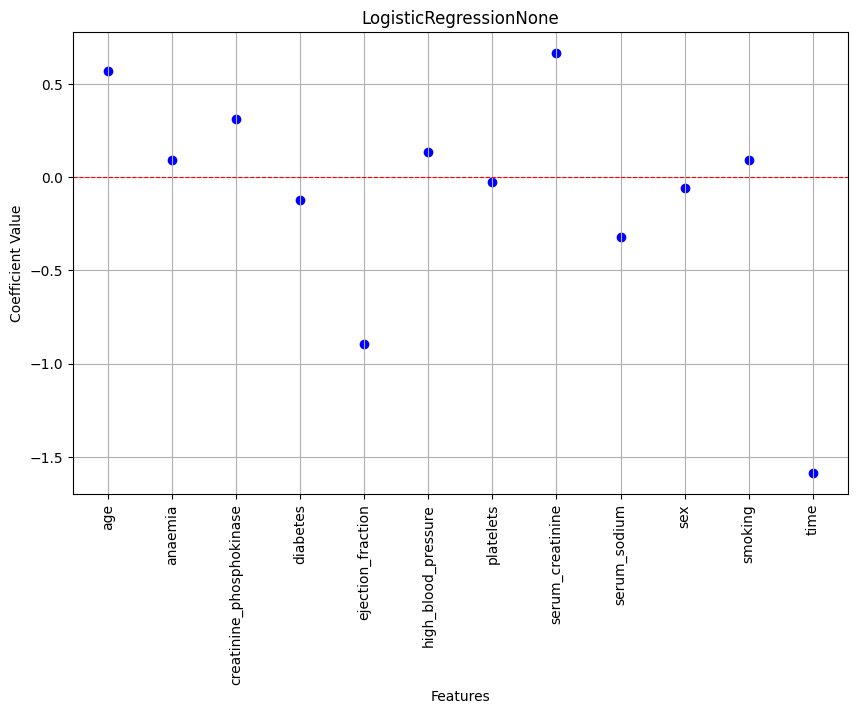

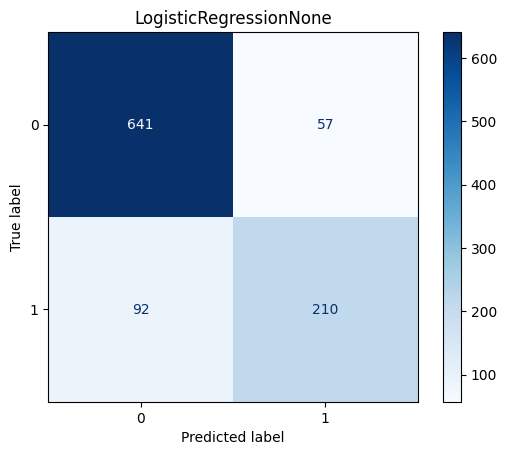

LogisticRegressionL1
LogisticRegressionL1
{'Class 0': {'Precision': 0.8671140939597315, 'Recall': 0.9255014326647565, 'F1': 0.8953568953568953}, 'Class 1': {'Precision': 0.796078431372549, 'Recall': 0.6721854304635762, 'F1': 0.7289048473967684}}


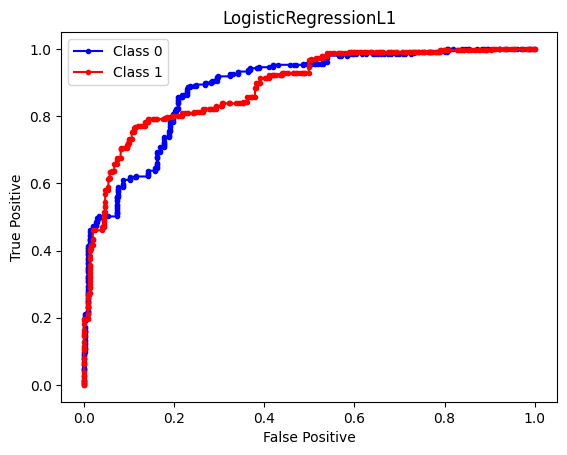

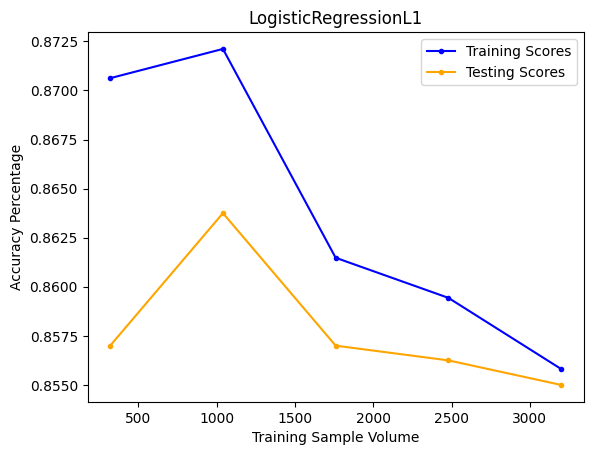

age: 0.3226341014564928
anaemia: 0.0
creatinine_phosphokinase: 0.0777934963131819
diabetes: 0.0
ejection_fraction: -0.594357904068721
high_blood_pressure: 0.0
platelets: 0.0
serum_creatinine: 0.43659286403736747
serum_sodium: -0.1359963533651025
sex: 0.0
smoking: 0.0
time: -1.226883983249278


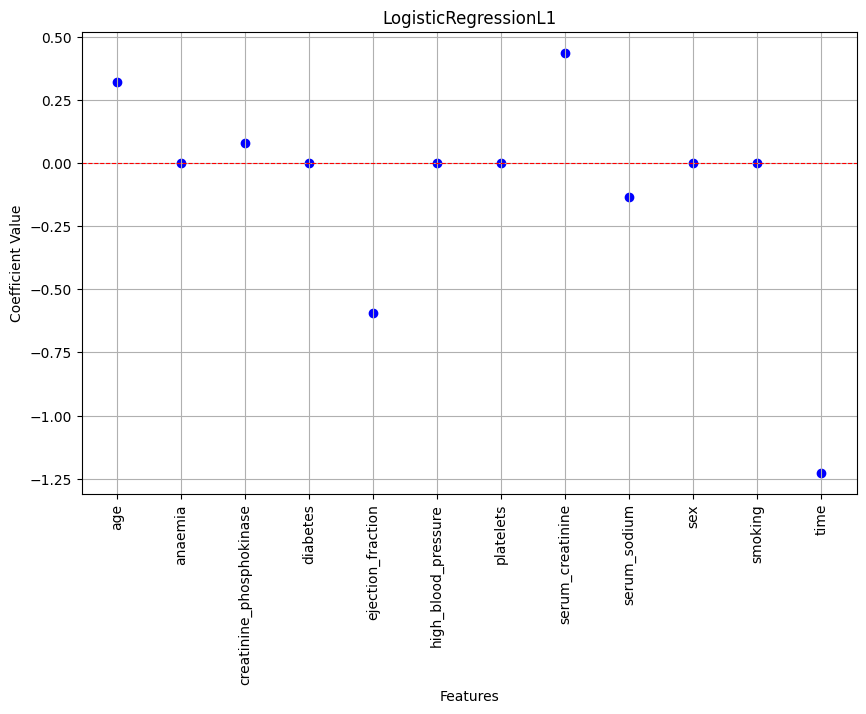

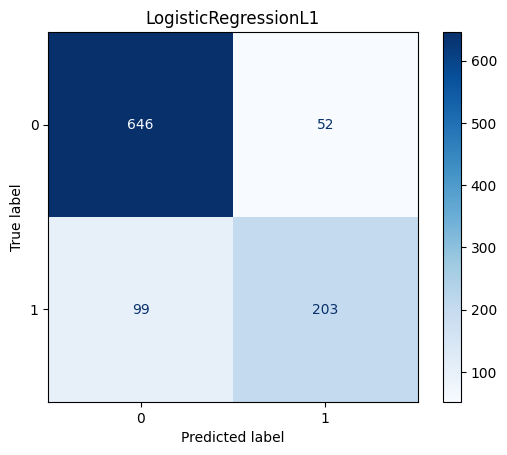

LogisticRegressionL2
LogisticRegressionL2
{'Class 0': {'Precision': 0.8564102564102564, 'Recall': 0.9570200573065902, 'F1': 0.9039242219215156}, 'Class 1': {'Precision': 0.8636363636363636, 'Recall': 0.6291390728476821, 'F1': 0.7279693486590038}}


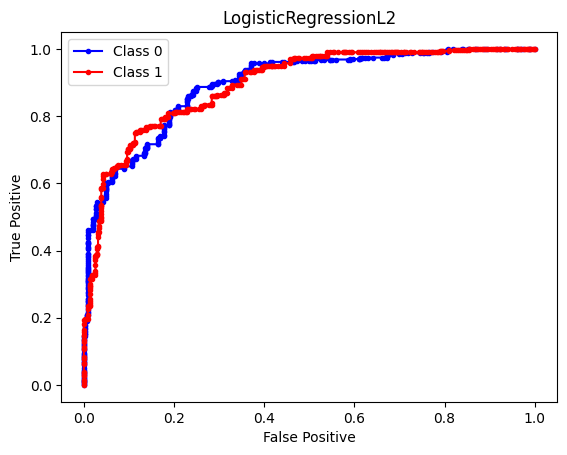

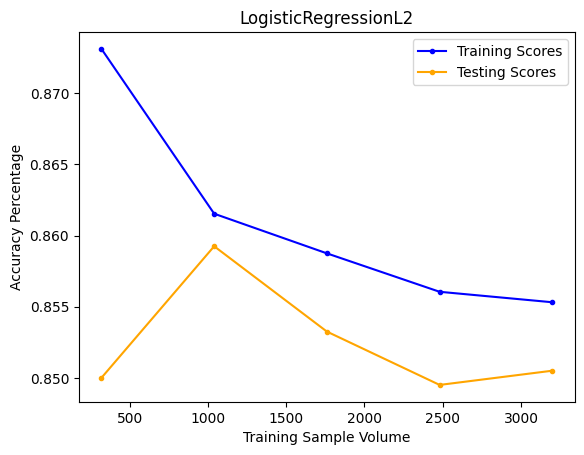

age: 0.35429847889443516
anaemia: 0.05384275980646735
creatinine_phosphokinase: 0.16969573501474447
diabetes: -0.025013714991024685
ejection_fraction: -0.518183969977428
high_blood_pressure: 0.0752339088012837
platelets: -0.022428799940113184
serum_creatinine: 0.40798474685165226
serum_sodium: -0.22253179927761205
sex: 0.016615458732765605
smoking: 0.009652226537688229
time: -0.9202022609012216


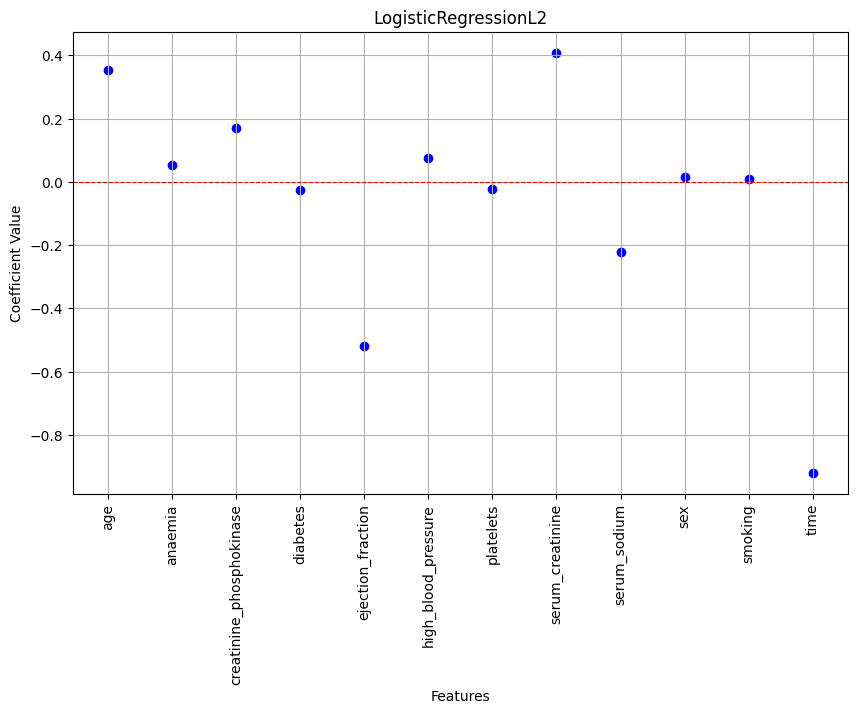

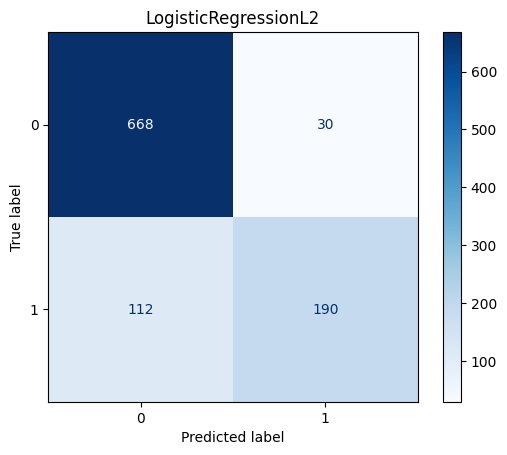

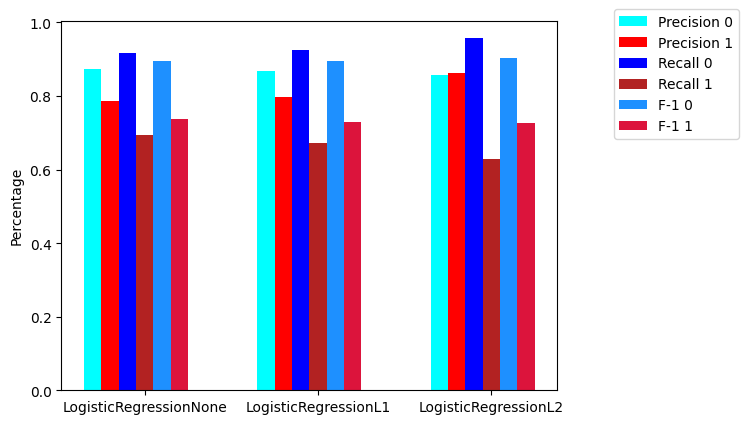

In [17]:
evaluators = [lgnEval,lrl1reval,lrl2reval]
p_0 = []; r_0 = []; f_0 = []
p_1 = []; r_1 = []; f_1 = []
names = []
for evaluator in evaluators:
    print(evaluator.model.name)
    prf = evaluator.get_prf()
    print(prf)
    p_0.append(prf["Class 0"]["Precision"]); r_0.append(prf["Class 0"]["Recall"]); f_0.append(prf["Class 0"]["F1"])
    p_1.append(prf["Class 1"]["Precision"]); r_1.append(prf["Class 1"]["Recall"]); f_1.append(prf["Class 1"]["F1"])
    names.append(evaluator.model.name)
    try:
        evaluator.show_ROC()
    except:
        print(f"ROC Not Available for {evaluator.model.name}")
    evaluator.show_learning_curve()
    evaluator.display_coefficients()
    evaluator.plot_coefficients()
    evaluator.get_confusion_matrix()

x_label = np.arange(len(names)) 
width = 0.1
plt.bar(x_label-(width*3), p_0, width, color='cyan') 
plt.bar(x_label-(width*2), p_1, width, color='red') 
plt.bar(x_label-(width), r_0, width, color='blue') 
plt.bar(x_label, r_1, width, color='firebrick') 
plt.bar(x_label+(width), f_0, width, color='dodgerblue') 
plt.bar(x_label+(width*2), f_1, width, color='crimson') 
plt.xticks(x_label, names)
plt.ylabel("Percentage") 
plt.legend(["Precision 0", "Precision 1", "Recall 0", "Recall 1", "F-1 0", "F-1 1"], bbox_to_anchor=(1.1, 1.05)) 
plt.show()

NuSupportVectorClassifier
NuSupportVectorClassifier
{'Class 0': {'Precision': 0.8337531486146096, 'Recall': 0.9484240687679083, 'F1': 0.8873994638069705}, 'Class 1': {'Precision': 0.8252427184466019, 'Recall': 0.5629139072847682, 'F1': 0.6692913385826771}}


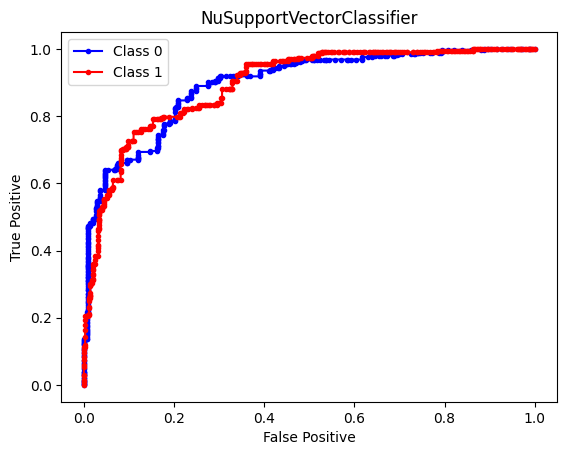

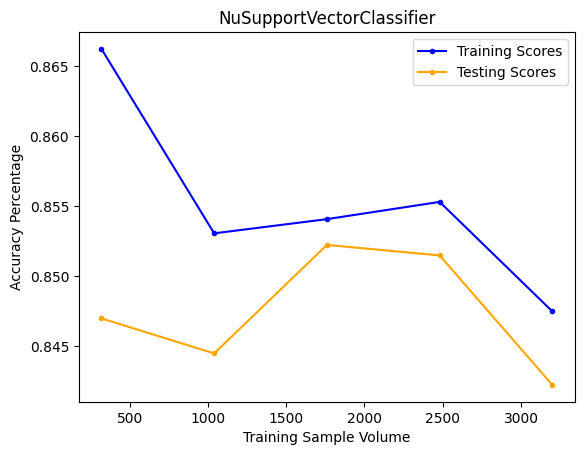

age: 0.27214104891422336
anaemia: 0.13640665937182928
creatinine_phosphokinase: 0.13391143427497348
diabetes: -0.013007130188686461
ejection_fraction: -0.37166560015856076
high_blood_pressure: 0.14054587186139003
platelets: 0.019087106343174336
serum_creatinine: 0.34381596512362683
serum_sodium: -0.16254914449540328
sex: 0.010808982002454864
smoking: -0.027423683390641135
time: -0.6709034235368434


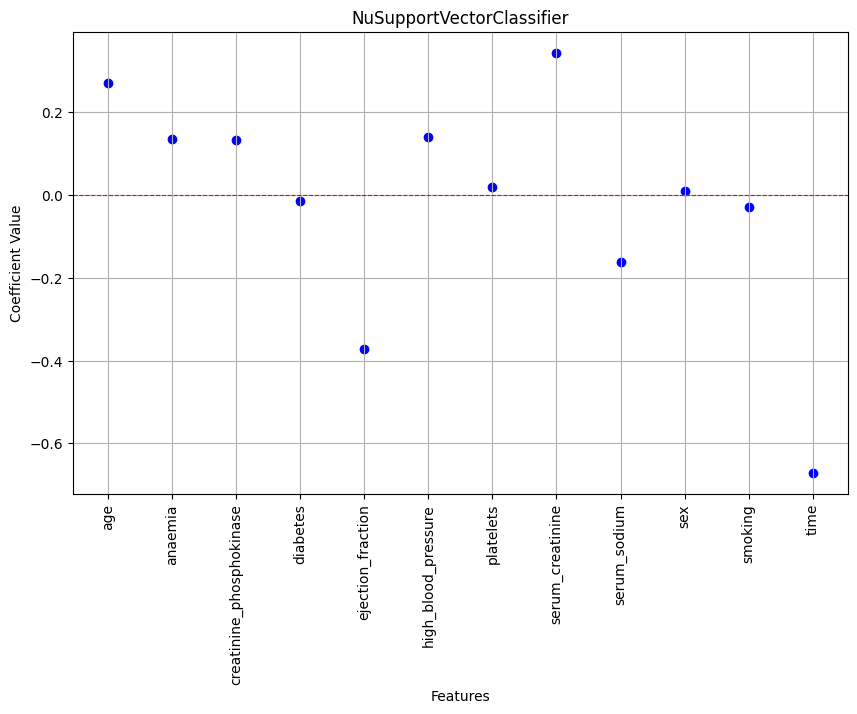

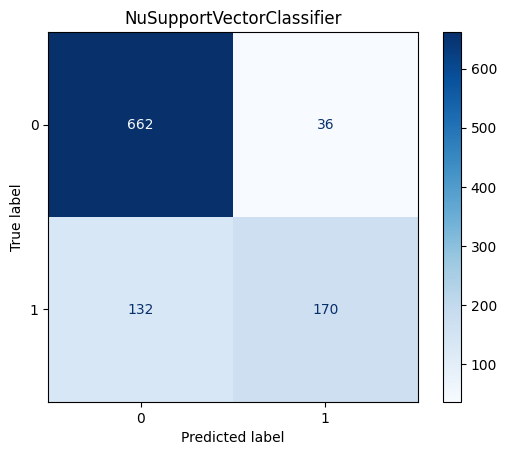

LinearSVCL2
LinearSVCL2
{'Class 0': {'Precision': 0.8784916201117319, 'Recall': 0.9011461318051576, 'F1': 0.8896746817538896}, 'Class 1': {'Precision': 0.7570422535211268, 'Recall': 0.7119205298013245, 'F1': 0.7337883959044369}}


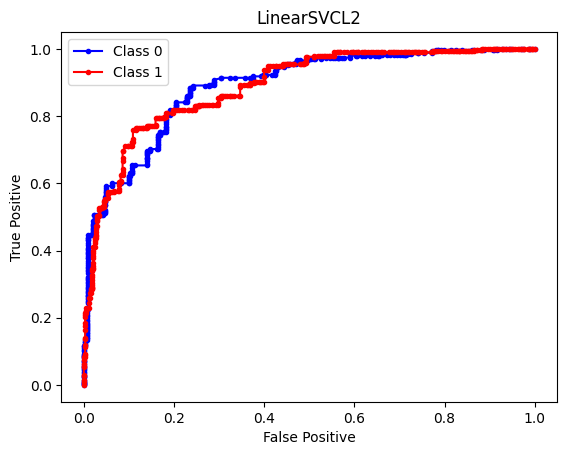

In [ ]:
evaluators = [nsvcEval,svcl2Eval,svcl1Eval]
p_0 = []; r_0 = []; f_0 = []
p_1 = []; r_1 = []; f_1 = []
names = []
for evaluator in evaluators:
    print(evaluator.model.name)
    prf = evaluator.get_prf()
    print(prf)
    p_0.append(prf["Class 0"]["Precision"]); r_0.append(prf["Class 0"]["Recall"]); f_0.append(prf["Class 0"]["F1"])
    p_1.append(prf["Class 1"]["Precision"]); r_1.append(prf["Class 1"]["Recall"]); f_1.append(prf["Class 1"]["F1"])
    names.append(evaluator.model.name)
    evaluator.show_ROC()
    evaluator.show_learning_curve()
    evaluator.display_coefficients()
    evaluator.plot_coefficients()
    evaluator.get_confusion_matrix()

x_label = np.arange(len(names)) 
width = 0.1
plt.bar(x_label-(width*3), p_0, width, color='cyan') 
plt.bar(x_label-(width*2), p_1, width, color='red') 
plt.bar(x_label-(width), r_0, width, color='blue') 
plt.bar(x_label, r_1, width, color='firebrick') 
plt.bar(x_label+(width), f_0, width, color='dodgerblue') 
plt.bar(x_label+(width*2), f_1, width, color='crimson') 
plt.xticks(x_label, names)
plt.ylabel("Percentage") 
plt.legend(["Precision 0", "Precision 1", "Recall 0", "Recall 1", "F-1 0", "F-1 1"], bbox_to_anchor=(1.1, 1.05)) 
plt.show()